In [1]:
# importing all the good stuff
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

Base.classes.keys()

['measurement', 'station']

In [3]:
Measurement = Base.classes.measurement
Station = Base.classes.station

session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


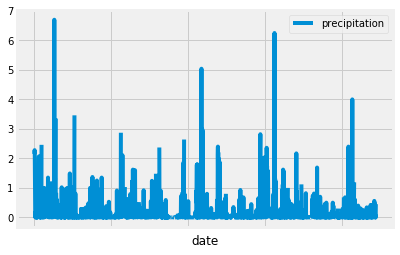

In [4]:
#Getting latest date and a year from that date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

l_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
p_yr = l_date - dt.timedelta(days=365)

#pulling the precipitation and dates from the database for the requested dates
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= p_yr).all()
df = pd.DataFrame(results, columns =['date', 'precipitation'])
df.set_index('date', inplace = True)
df = df.sort_values('date')

#plotting the requested data
df.plot()
plt.show()

In [5]:
#summry stats for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [6]:
#number of stations
session.query(Measurement).group_by(Measurement.station).count()

9

In [7]:
#getting the number of observations per station
sel = [Station.station,
      func.count(Measurement.id)]

station_results = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [8]:
#Getting the minimum, maximum, and average temperature observations from the station with the most observations
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

most_active_station = session.query(*sel).\
    filter(Measurement.station == station_results[0][0]).all()

most_active_station[0][0]
print(f'The most active station was {station_results[0][0]}')
print(f"It recorded a minimum temperature of {most_active_station[0][0]}")
print(f"It recorded a maximum temperature of {most_active_station[0][1]}")
print(f"It recorded a average temperature of {most_active_station[0][2]}")

The most active station was USC00519281
It recorded a minimum temperature of 54.0
It recorded a maximum temperature of 85.0
It recorded a average temperature of 71.66378066378067


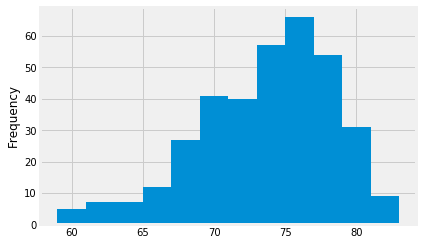

In [9]:
#getting the latest years worth of temperature observations from the station with the most observations
latest_date2 = session.query(Measurement.date).\
    filter(Measurement.station == station_results[0][0]).\
    order_by(Measurement.date.desc()).first()


l_date2 = dt.datetime.strptime(latest_date2[0], '%Y-%m-%d')
p_yr2 = l_date2 - dt.timedelta(days=365)

results2 = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= p_yr2).\
    filter(Measurement.station == station_results[0][0]).all()

df2 = pd.DataFrame(results2, columns =['date', 'Temperature'])
df2.set_index('date', inplace = True)

#Plotting that data

plt.hist(df2['Temperature'], bins = 12)
plt.ylabel('Frequency')
plt.show()